# Single experiments vs. batches of experiments

This notebook is a part of the series about using ProcessOptimizer to guide a gold
mining expedition. For an overview, go to the markdown file gold_mining.md

## What we learned last time

We define our map by setting `coordinates`, and our `score()` function. We then 
initialise a ProcessOptimizer on the `coordinates`. We then do 10 cycles of asking for
a place to dig, sending Ms. Dixon's team to dig, and telling the ProcessOptimizer how
much gold was found. 

We dug at [12.75, 5.25] and found 2.7 mg gold.
We dug at [2.25, 14.25] and found 1.3 mg gold.
We dug at [8.25, 9.75] and found 2.6 mg gold.
We dug at [0.75, 12.75] and found 1.9 mg gold.
We dug at [11.25, 3.75] and found 2.8 mg gold.
We dug at [3.75, 8.25] and found 2.3 mg gold.
We dug at [14.25, 2.25] and found 1.4 mg gold.
We dug at [6.75, 11.25] and found 2.3 mg gold.
We dug at [5.25, 0.75] and found 3.0 mg gold.
We dug at [9.75, 6.75] and found 2.9 mg gold.


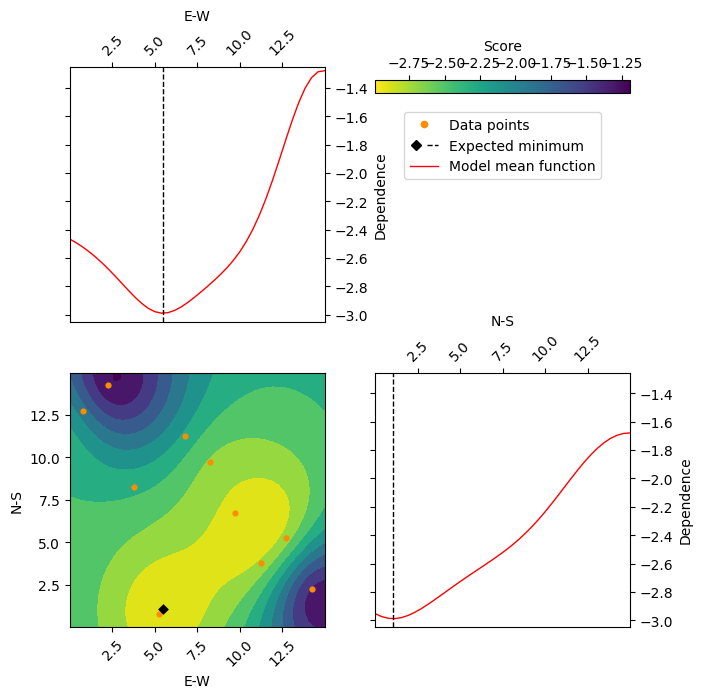

In [1]:
import numpy as np
import ProcessOptimizer

#Setting random seed to ensure reproducible behaviour
np.random.seed(42)

coordinates = [(0, 15.0),(0,15.0)]

def score(coordinates, verbose = True):
    """ Modified Branin-Hoo function. It has three local minima.
    More details: <http://www.sfu.ca/~ssurjano/branin.html>
    """
    x = 10-coordinates[0]
    y = coordinates[1]
    gold_found = ((y - 1/8 * x ** 2 + 1.6 * x - 6) ** 2 + 10 * np.cos(x) - 299)/100
    if verbose:
        print(f"We dug at {coordinates} and found {-round(gold_found*10)/10} mg gold.")
    return gold_found

opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
# For each of the first 10 positions
for index in range(10):
    # Find the place to dig
    new_dig_site = opt.ask()
    # Digging for gold
    gold_found = score(new_dig_site)
    # Telling the optimiser how uch gold we found
    result = opt.tell(new_dig_site, gold_found)
# plotting
ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"]);

## One experiment at a time

Last time, we sent Ms. Dixon's team out for one dig at a time.

In [2]:
# Finding new dig site.
new_dig_site=opt.ask()
# Digging and finding gold.
gold_found = score(new_dig_site)
# Telling ProcessOptimizer how much gold we found at the new dig site
opt.tell(new_dig_site,gold_found);

We dug at [7.212687493096595, 2.928665444152217] and found 3.1 mg gold.


## Getting several suggestions at once

But after talking to Ms. Dixon, we learn that her team spends a lot of time driving back
and forth between the headquarters and the plot. So they would be much more efficient if
they could get a list of, say, 7 places to dig at at a time. Then they can go on a tour
to these 7 sites, and only then return to the headquarters to tell how much gold they
found at each dig site, and get a new list of places to dig. We can do this by setting
the `n_points` parameter of the `opt.ask()` method.

Note that we also tell the ProcessOptimizer about all seven dig sites in one call to
`tell()`. This can be done regardless of how the dig sites are found.

Going out on tour number 1
We dug at [14.31027318127179, 11.89763924056988] and found 2.9 mg gold.
We dug at [10.381496416666124, 13.692252052277178] and found 2.4 mg gold.
We dug at [2.6981411326473164, 5.926898840170584] and found 2.7 mg gold.
We dug at [0.14669485401716395, 7.566662755617802] and found 2.8 mg gold.
We dug at [5.852490071669459, 4.664584353635048] and found 2.9 mg gold.
We dug at [12.11231740674332, 0.16310415714129384] and found 2.1 mg gold.
We dug at [11.67038274091478, 10.3588112495328] and found 3.0 mg gold.
Average amount of gold found in tour 1: 2.690507295978912 mg.
Going out on tour number 2
We dug at [0.0, 1.835433218168891] and found 3.1 mg gold.
We dug at [4.480756184912051, 13.173785157308668] and found 1.4 mg gold.
We dug at [1.6326954427313367, 9.288754278380999] and found 2.4 mg gold.
We dug at [8.905259331034385, 2.415306183763906] and found 2.9 mg gold.
We dug at [6.3640562440763935, 7.267095218735468] and found 2.8 mg gold.
We dug at [13.27873118286

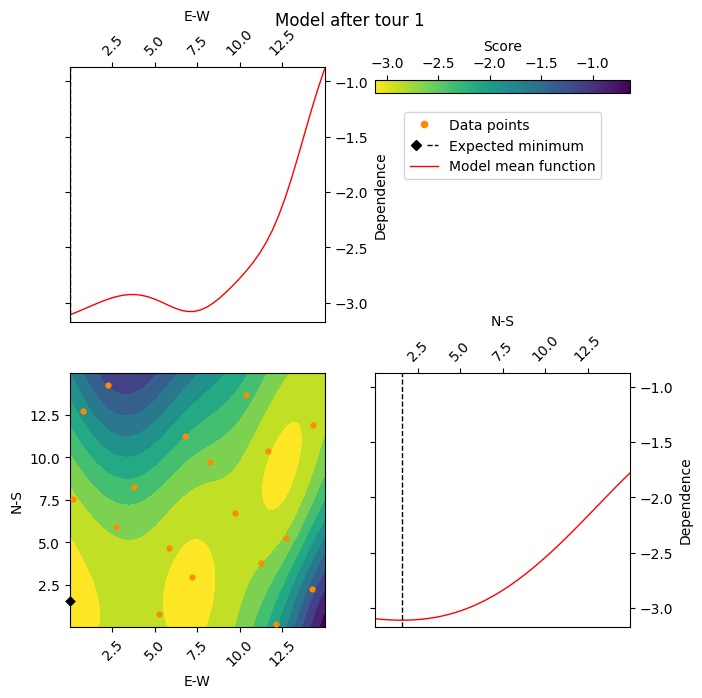

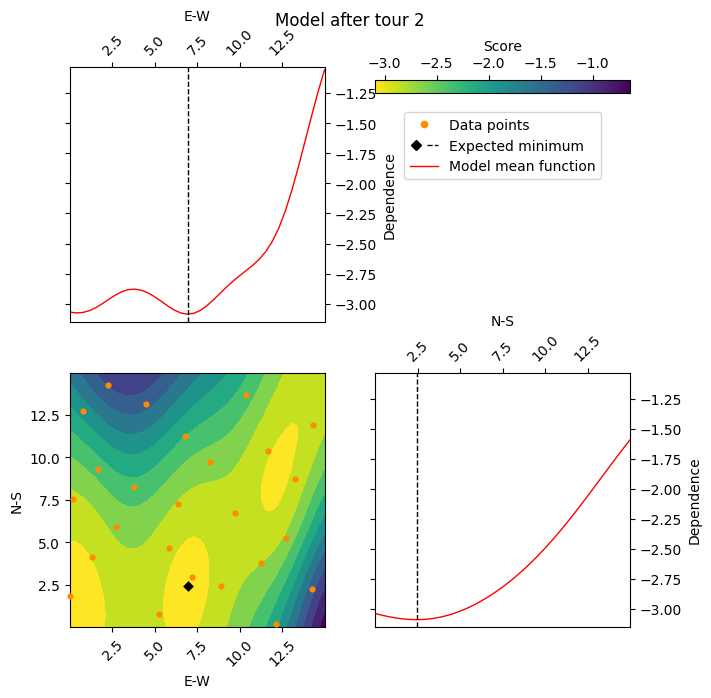

In [3]:
dig_sites_per_tour = 7
number_of_tours = 2
for tour_number in range(number_of_tours):
    print(f"Going out on tour number {tour_number+1}")
    # Finding new spots to dig at
    new_position_list = opt.ask(n_points=dig_sites_per_tour)
    # Starting the list of results of digs.
    gold_found = []
    for dig_number in range(len(new_position_list)):
        # Fishing out the next position
        dig_position = new_position_list[dig_number]
        # Digging and adding the result to the list of results of digs
        gold_found.append(score(dig_position))
    print(f"Average amount of gold found in tour {tour_number+1}: {-np.mean(gold_found)} mg.")
    # Telling the ProcessOptimizer about the result of the new digs
    opt.tell(new_position_list, gold_found)
    ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title=f"Model after tour {tour_number+1}")

## Knowledge gap

Notice that the average amount of gold found is lower than when we did single digs.
That is a natural consequence of us having less knowledge when planning the digs.
Before, when we planned dig 17, we had information of the amount of gold found in all
of the 16 first digs. Now, we have to plan dig 17 with only the information from the
first 10 digs.

## Strategies

There are different possible strategies to handle this lack of knowledge when being
asked for more than one new suggestion. The default strategy of ProcessOptimizer is to
use the normal approach for the first point, and try to spread the rest of the point as
far as possible in the space. It does this using Steinerberger sampling, see 
https://arxiv.org/abs/1902.03269. This was the strategy used in the previous example.

Another possibility is to "lie" to the optimizer about the amount of gold on the dig
sites it has suggested, and then ask for a new suggestion. We can either tell the
ProcessOptimizer that they have the same value as the minimum, mean or maximum of the
amounts of gold we have found at any dig site. This is done by setting the `strategy`
parameter to `"cl_min"`, `"cl_mean"`, or `"cl_max"`, respectively.

Let's try the last three strategies:

Trying strategy cl_min
We dug at [7.212687387033412, 2.9286653648510494] and found 3.1 mg gold.
We dug at [13.999304942719082, 11.973098174915483] and found 3.0 mg gold.
We dug at [12.211759299388318, 8.220529949391016] and found 3.0 mg gold.
We dug at [6.323031575742538, 1.8240429900509496] and found 3.1 mg gold.
We dug at [0.0, 0.0] and found 3.0 mg gold.
We dug at [0.0, 4.360847534154892] and found 3.0 mg gold.
We dug at [0.0, 2.7448149957074293] and found 3.1 mg gold.
Average amount of gold found with strategy cl_min: 3.041601562768137
Trying strategy cl_mean
We dug at [5.598121325828468, 1.1773476814316854] and found 3.0 mg gold.
We dug at [9.856135434945314, 5.762098388328305] and found 2.9 mg gold.
We dug at [11.407257240987644, 8.890057338980622] and found 3.0 mg gold.
We dug at [7.615137464633126, 4.132244498140041] and found 3.0 mg gold.
We dug at [3.4319159526099674, 0.0] and found 2.9 mg gold.
We dug at [8.34657918987983, 0.0] and found 2.9 mg gold.
We dug at [3.87107807833

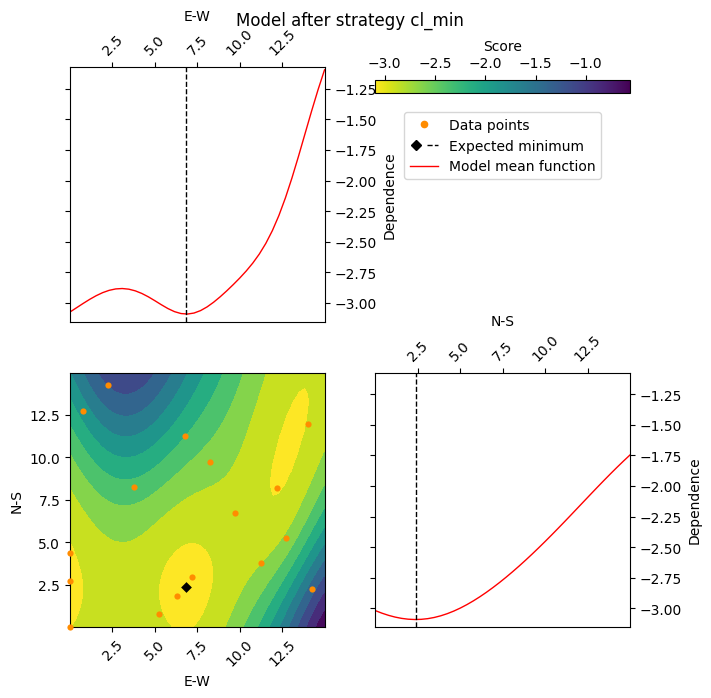

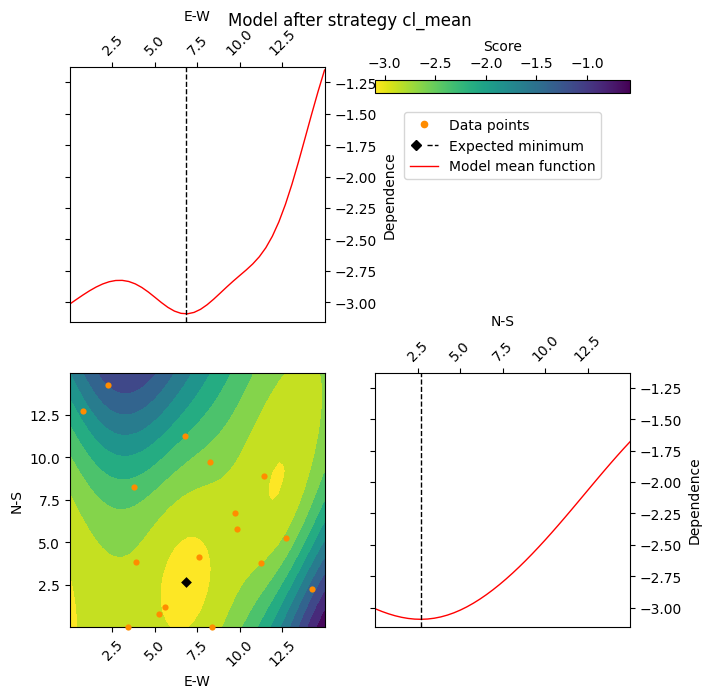

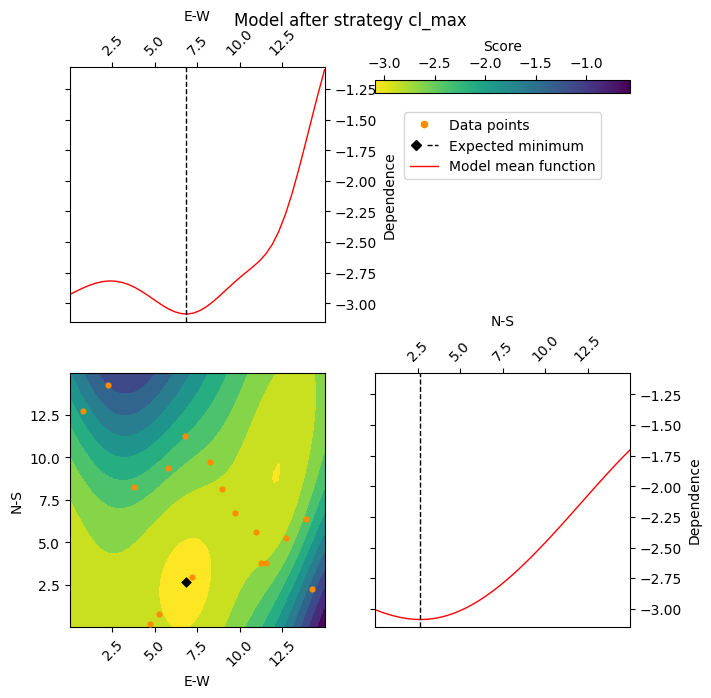

In [4]:
strategy_list = ["cl_min", "cl_mean","cl_max"]
for strategy in strategy_list:
    # Starting the optimizer
    opt = ProcessOptimizer.Optimizer(dimensions=coordinates)
    # Telling the optimiser how much gold we found at the first 10 points
    for index in range(10):
        # Find the place to dig
        new_dig_site = opt.ask()
        # Digging for gold
        gold_found = score(new_dig_site, verbose=False)
        # Telling the optimiser how much gold we found
        result = opt.tell(new_dig_site, gold_found)

    # Now we can use the chosen strategy.
    print(f"Trying strategy {strategy}")
    # Asking the ProcessOptimizer for new points with the chosen strategy.
    new_position_list = opt.ask(n_points = dig_sites_per_tour, strategy = strategy)
    # Starting the list of results of digs.
    gold_found = []
    for dig_number in range(len(new_position_list)):
        # Fishing out the next position
        dig_position = new_position_list[dig_number]
        # Digging and adding the result to the list of results of digs
        gold_found.append(score(dig_position))
        # Telling the ProcessOptimizer about the result of the new digs
    print(f"Average amount of gold found with strategy {strategy}: {-np.mean(gold_found)}")
    opt.tell(new_position_list, gold_found)
    ProcessOptimizer.plot_objective(result=result,pars="expected_minimum",dimensions = ["E-W","N-S"],title=f"Model after strategy {strategy}")